# CA Public School Success Model

## Question 

> Can we use student demographics and neighborhood characteristics to predict academic success for a school in a given zip code?

## Purpose

>     
    - Inform district leaders how to better support specific school sites 
    - Provide insight into where to build a new school
    - Shed light to a larger system at play in the way success is defined that determine how resources and funds are allocated

## Definitions

>    
    - Academic Success: English Language Arts/Literacy and Mathematics (CAASPP) Scores
    - 


## Data Sources

>    
    - data bank: https://caaspp-elpac.cde.ca.gov/caaspp/
    - data key: https://caaspp-elpac.cde.ca.gov/caaspp/research_fixfileformat19
    - greatschools.org : also sourced data from CA dept of Ed!! parallels in data = GOOD
    - trulia.com

## Process
>
    - Collect data
        - CA Dept of Ed
        - scrape data
        - merge data into one dataframe
    - Clean data
        - handle nulls and incomplete rows
    - Filter data 
        - by CSD code + student group to avoid duplicate counts
        - exclude charter schools for simplicity
    - [Cross] Validate Data
    - Build & Select Models
    - Interpret

## Results and Insights

## Future Work
>
    Room for improvement:
    - scraped data greatschools was also sourced from the Dept of Ed data - meant i could trust the data, but there may be colinearity because of it
    - make feature based on district average
    - include more features based on the neighborhood: number of parks, crime rate

## Appendix

>     
Packages Used:
    - numpy
    - pandas 



## Data Collection and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)
pd.set_option('display.precision', 3)

%precision 3
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last"

In [52]:
#import csv's into dataframes
test_scores = pd.read_csv('student groups/sb_ca2019_all_csv_v2.txt')
school_info = pd.read_csv('ca test score data/sb_ca2019entities_csv.txt', encoding='latin-1')

In [52]:
subgroups = pd.read_csv('Subgroups.txt')
tests = pd.read_csv('Tests.txt')

In [53]:
#combine dataframes
master_df = pd.merge(test_scores,school_info,on=['County Code', 'District Code', 'School Code', 'Filler', 'Test Year'])

In [83]:
master_df.drop(['Filler', 'Test Year', 'Test Type'], axis=1, inplace= True)

In [79]:
#filter for public schools
master_df = master_df[master_df['Type Id'] == 7]

In [91]:
pickle.dump(master_df, open('master_df','wb'))

In [165]:
master_df = pickle.load(open('master_df','rb'))

In [ ]:
master_df.nunique()

In [278]:
HS_df = master_df.loc[master_df['Grade'] == 11]

In [ ]:
HS_df.reset_index()
HS_df.index[:30]

In [ ]:
HS_df['Zip Code'].unique()[:200]

In [283]:
zipcodes = pd.read_csv("zipcodes.csv")
zipcodes = zipcodes.astype(str)
HS_df = HS_df.merge(zipcodes, on=['Zip Code'])

In [ ]:
HS_df.head(5)

In [167]:
HS_df.nunique().head()
#2137 public high schools in CA excluding charters

County Code                       57
District Code                    474
School Code                     2137
Subgroup ID                       51
Total Tested At Entity Level     950
dtype: int64

In [168]:
HS_df.loc[HS_df['District Code']==68478, 'School Name'].unique()

array(['Jordan (June) School for Equity', 'S.F. International High',
       'Academy (The)- SF @McAteer', 'Wells (Ida B.) High',
       'Downtown High', 'Independence High',
       'Wallenberg (Raoul) Traditional High',
       'Burton (Phillip and Sala) Academic High', 'Balboa High',
       'Asawa (Ruth) SF Sch of the Arts, A Public School',
       'Marshall (Thurgood) High', 'Galileo High',
       'Lincoln (Abraham) High', 'Lowell High', 'Mission High',
       "O'Connell (John) High", 'Washington (George) High'], dtype=object)

In [504]:
SF_df = HS_df.loc[HS_df['County Code']==38]
SF_df.nunique()

County Code                            1
District Code                          2
School Code                           22
Subgroup ID                           50
Total Tested At Entity Level         231
Total Tested with Scores             227
Grade                                  1
Test Id                                2
CAASPP Reported Enrollment           192
Students Tested                      231
Mean Scale Score                     667
Percentage Standard Exceeded         434
Percentage Standard Met              430
Percentage Standard Met and Above    507
Percentage Standard Nearly Met       420
Percentage Standard Not Met          535
Students with Scores                 227
Area 1 Percentage Above Standard     450
Area 1 Percentage Near Standard      458
Area 1 Percentage Below Standard     540
Area 2 Percentage Above Standard     456
Area 2 Percentage Near Standard      456
Area 2 Percentage Below Standard     518
Area 3 Percentage Above Standard     438
Area 3 Percentag

In [285]:
highschools = HS_df[['School Name', 'CITY', 'School Code']].drop_duplicates()
highschools.shape

(2110, 3)

In [286]:
highschools_list = []
for index, row in highschools.iterrows():
    search = [row['School Name'], row['CITY'], row['School Code']]
    highschools_list.append(search)

# WebScraping
>
    greatschools.org : college readiness & equity overview scores
    trulia.com : crime rates

In [336]:
from bs4 import BeautifulSoup
import requests
import time, os

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)

In [292]:
from selenium.common.exceptions import NoSuchElementException

def GS_scrape(school_info):
    school = school_info[0]
    city = school_info[1]
    code = school_info[2]
    
    #search for school
    GS_search = driver.find_element_by_xpath('//input[@class="full-width pam search_form_field"]').send_keys(school + ' ' + city + Keys.ENTER)
    #GS_search.click()
    #GS_search.clear()
    #GS_search.send_keys(school + ' ' + district + Keys.ENTER)
    time.sleep(1)
    
    headers = ['School Code', 'College Readiness Score', 'Equity Score']
    
    try:
        #enter school profile
        GS_search = driver.find_element_by_xpath('//a[@class="name"]')
        GS_search.click()
        time.sleep(2)
    
        soup = BeautifulSoup(driver.page_source)
        #0: Overall
        #1: College Readiness 
        #2: Test Scores 
        #3: Equity
        #4: Low-income
        ratings = soup.find_all('div', {'class':'circle-rating--medium'})
        #get scores
        college = ratings[1].text[0]
        equity = ratings[3].text.lstrip()[0]
        
        if college.isnumeric() == False:
            college = '*'
        if equity.isnumeric() == False:
            equity = '*'

        scores = dict(zip(headers, [code, college, equity]))

        return scores

    except NoSuchElementException:  
        scores = dict(zip(headers, [code, '*', '*']))
        return scores
        pass
    
    except IndexError:
        scores = dict(zip(headers, [code, '*', '*']))
        return scores
        pass

In [293]:
#SCRAPE DATA GREAT SCHOOLS
highschools_data = []
headers = ['School Code', 'College Readiness Score', 'Equity Score']

driver.get('https://www.greatschools.org/')
time.sleep(1)  #pause to be sure page has loaded

for row in highschools_list:
    highschools_scores = GS_scrape(row)
    highschools_data.append(highschools_scores)
    

In [294]:
pickle.dump(highschools_data, open('highschools_data','wb'))

In [500]:
highschools_data = pickle.load(open('highschools_data','rb'))

In [310]:
driver.quit()

In [229]:
test_df = pd.DataFrame(SF_data)
test1 = dict(zip(headers, [333, 6, 7]))
test_df = test_df.append(test1, ignore_index=True)
test_df

,School Code,College Readiness Score,Equity Score
0,102103,2,1
1,119875,1,1
2,119958,*,*
3,3830031,*,1
4,3830064,*,*
5,3830197,*,*
6,3830205,8,5
7,3830254,6,4
8,3830288,6,5
9,3830387,*,*


In [501]:
HS_df = HS_df.merge(highschools_ratings, on=['School Code'])
#HS_df.info();

In [307]:
pickle.dump(HS_df, open('HS_df','wb'))

In [752]:
HS_df = pickle.load(open('HS_df','rb'))

In [319]:
filter_df = HS_df[HS_df.apply(lambda row: row.astype(str).str.contains('b', case=False).any(), axis=1)]
filter_df.shape

(42840, 37)

In [753]:
economic = ((HS_df['Subgroup ID'] == 3) | (HS_df['Subgroup ID'] == 4)) & (HS_df['Test Id']==1)
economic_df = HS_df.loc[economic, ['School Code', 'Subgroup ID', 'Total Tested with Scores']]
economic_df = economic_df.pivot(index = 'School Code', columns = 'Subgroup ID')
economic_df = pd.DataFrame(economic_df.to_records())
economic_df.columns = ['School Code', 'Economically Disadvantaged', 'Not Economically Disadvantaged']
economic_df

,School Code,Economically Disadvantaged,Not Economically Disadvantaged
0,100057,*,*
1,100081,291,317
2,100180,4,*
3,100198,274,277
4,100255,226,215
...,...,...,...
2103,6114011,21,26
2104,6114698,278,332
2105,6115133,33,NaN
2106,6119556,44,55


In [754]:
ethnicity = (((HS_df['Subgroup ID'] == 74) | (HS_df['Subgroup ID'] == 76) | (HS_df['Subgroup ID'] == 78) | (HS_df['Subgroup ID'] == 80)) & (HS_df['Test Id']==1))
ethnicity_df = HS_df.loc[ethnicity, ['School Code', 'Subgroup ID', 'Total Tested with Scores']]
ethnicity_df = ethnicity_df.pivot(index = 'School Code', columns = 'Subgroup ID')
ethnicity_df = pd.DataFrame(ethnicity_df.to_records())
ethnicity_df.columns = ['School Code', 'Black', 'Asian', 'Latinx', 'White']
ethnicity_df

,School Code,Black,Asian,Latinx,White
0,100057,NaN,NaN,NaN,*
1,100081,65,6,498,18
2,100180,NaN,NaN,NaN,*
3,100198,25,13,474,32
4,100255,*,NaN,433,*
...,...,...,...,...,...
2090,6114011,15,4,21,*
2091,6114698,55,12,439,60
2092,6115133,NaN,NaN,36,NaN
2093,6119556,NaN,16,23,55


In [755]:
model_data = HS_df.merge(economic_df, on=['School Code'])
model_data = model_data.merge(ethnicity_df, on=['School Code'])
model_data[(model_data['Test Id']==1) & (model_data['Subgroup ID']==1)].head(40);

In [ ]:
SF = HS_df.loc[HS_df['District Code']==68478]
SF.iloc[110:180]

In [469]:
temp2 = temp[temp["School Code"]==138693][["Subgroup ID", "Total Tested with Scores"]]

# English Model 

In [651]:
model_data.columns

Index(['County Code', 'District Code', 'School Code', 'Subgroup ID',
       'Total Tested At Entity Level', 'Total Tested with Scores', 'Grade',
       'Test Id', 'CAASPP Reported Enrollment', 'Students Tested',
       'Mean Scale Score', 'Percentage Standard Exceeded',
       'Percentage Standard Met', 'Percentage Standard Met and Above',
       'Percentage Standard Nearly Met', 'Percentage Standard Not Met',
       'Students with Scores', 'Area 1 Percentage Above Standard',
       'Area 1 Percentage Near Standard', 'Area 1 Percentage Below Standard',
       'Area 2 Percentage Above Standard', 'Area 2 Percentage Near Standard',
       'Area 2 Percentage Below Standard', 'Area 3 Percentage Above Standard',
       'Area 3 Percentage Near Standard', 'Area 3 Percentage Below Standard',
       'Area 4 Percentage Above Standard', 'Area 4 Percentage Near Standard',
       'Area 4 Percentage Below Standard', 'Type Id', 'County Name',
       'District Name', 'School Name', 'Zip Code', 'CITY',


In [756]:
model_columns = ['School Code', 'Total Tested with Scores', 'Mean Scale Score', 'Percentage Standard Exceeded',
       'Percentage Standard Met', 'Percentage Standard Met and Above',
       'Percentage Standard Nearly Met', 'Percentage Standard Not Met','Economically Disadvantaged',
       'Not Economically Disadvantaged', 'Black', 'Asian', 'Latinx', 'White'] #'College Readiness Score', 'Equity Score',
english_model = model_data[(model_data['Subgroup ID']==1)] 
english_model = english_model[(english_model['Test Id']==1)] 
english_model = english_model[model_columns]
english_model = english_model.replace('*',np.nan)
english_model.head()

,School Code,Total Tested with Scores,Mean Scale Score,Percentage Standard Exceeded,Percentage Standard Met,Percentage Standard Met and Above,Percentage Standard Nearly Met,Percentage Standard Not Met,Economically Disadvantaged,Not Economically Disadvantaged,Black,Asian,Latinx,White
0,130401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,130419,14,NaN,NaN,NaN,NaN,NaN,NaN,6,8,NaN,NaN,8,NaN
132,138339,328,2526.9,13.41,21.34,34.76,19.51,45.73,177,151,21,24,236,8
228,161192,6,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN
252,110460,59,2505.4,1.69,15.25,16.95,42.37,40.68,38,21,NaN,NaN,47,5


In [14]:
english_model = english_model.dropna(subset=['Mean Scale Score','Economically Disadvantaged'])
english_model = english_model.rename({'Total Tested with Scores':'Total'}, axis=1)

#switch type to numeric
# english_model['Economically Disadvantaged'] = pd.to_numeric(english_model['Economically Disadvantaged'])
# english_model['Not Economically Disadvantaged'] = pd.to_numeric(english_model['Economically Disadvantaged'])
# english_model['Total'] = pd.to_numeric(english_model['Total'])
for label in ['Total', 'Economically Disadvantaged', 'Not Economically Disadvantaged', 'Black', 'Asian', 'Latinx', 'White']:
    english_model[label] = pd.to_numeric(english_model[label])

#percentages
# english_model['Economically Disadvantaged'] = english_model['Economically Disadvantaged'].divide(english_model['Total'])
# english_model['Not Economically Disadvantaged'] = english_model['Not Economically Disadvantaged'].divide(english_model['Total'])
for label in ['Economically Disadvantaged', 'Not Economically Disadvantaged', 'Black', 'Asian', 'Latinx', 'White']:
    english_model[label] = english_model[label].divide(english_model['Total'])

In [758]:
pickle.dump(english_model, open('english_model','wb'))

In [80]:
english_model = pickle.load(open('english_model','rb'))

In [81]:
english_model['Not Economically Disadvantaged'] = english_model['Not Economically Disadvantaged'].fillna(english_model['Not Economically Disadvantaged'].mean())
english_model['Black'] = english_model['Black'].fillna(.054)
english_model['Asian'] = english_model['Asian'].fillna(.093)
english_model['Latinx'] = english_model['Latinx'].fillna(.546)
english_model['White'] = english_model['White'].fillna(.229)

In [82]:
english_model.iloc[500:550]

,School Code,Total,Mean Scale Score,Percentage Standard Exceeded,Percentage Standard Met,Percentage Standard Met and Above,Percentage Standard Nearly Met,Percentage Standard Not Met,Economically Disadvantaged,Not Economically Disadvantaged,Black,Asian,Latinx,White
43891,124495,92,2567.4,13.04,30.43,43.48,35.87,20.65,0.674,0.326,0.043,0.093,0.946,0.229
43951,124503,91,2528.5,6.59,26.37,32.97,30.77,36.26,0.516,0.484,0.077,0.093,0.923,0.229
44009,124511,104,2560.8,13.46,28.85,42.31,28.85,28.85,0.471,0.529,0.067,0.093,0.913,0.229
44077,126474,35,2557.8,11.43,31.43,42.86,25.71,31.43,0.629,0.371,0.054,0.093,1.000,0.229
44125,1931989,17,2491.5,0.00,29.41,29.41,5.88,64.71,0.529,0.471,0.054,0.093,1.000,0.229
44167,1933381,598,2621.3,26.09,42.98,69.06,21.07,9.87,0.502,0.498,0.054,0.093,0.988,0.229
44239,126482,128,2501.8,6.25,19.53,25.78,28.91,45.31,0.719,0.281,0.203,0.093,0.773,0.229
44309,126490,102,2481.2,3.92,15.69,19.61,26.47,53.92,0.333,0.667,0.127,0.093,0.863,0.229
44371,126508,85,2471.2,1.18,14.12,15.29,22.35,62.35,0.435,0.565,0.129,0.093,0.859,0.229
44433,1995794,70,2422.3,0.00,2.86,2.86,14.29,82.86,0.714,0.286,0.400,0.093,0.571,0.229


## Regression

In [231]:
## Train/Test Split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

X = english_model.loc[:,['Total', 'Economically Disadvantaged', 'Black', 'Asian', 'Latinx', 'White']]
y = english_model['Mean Scale Score'].astype(float)
# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=22)



In [232]:
## Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [233]:
#models

lm = LinearRegression()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)

In [234]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')


Linear Regression val R^2: 0.612
Ridge Regression val R^2: 0.612


## Cross Validation

In [185]:
#cross validation

kf = KFold(n_splits=5, shuffle=True, random_state = 22)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.548755376593919, 0.5877621194731015, 0.6761528128735164, 0.601811989565253, 0.6602701827970763]
Ridge scores:  [0.5487768827327597, 0.5877567432512769, 0.6761182135078928, 0.6018511650926025, 0.6602696782148132] 

Simple mean cv r^2: 0.615 +- 0.047
Ridge mean cv r^2: 0.615 +- 0.047


In [186]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.621


In [187]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

/Applications/miniconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


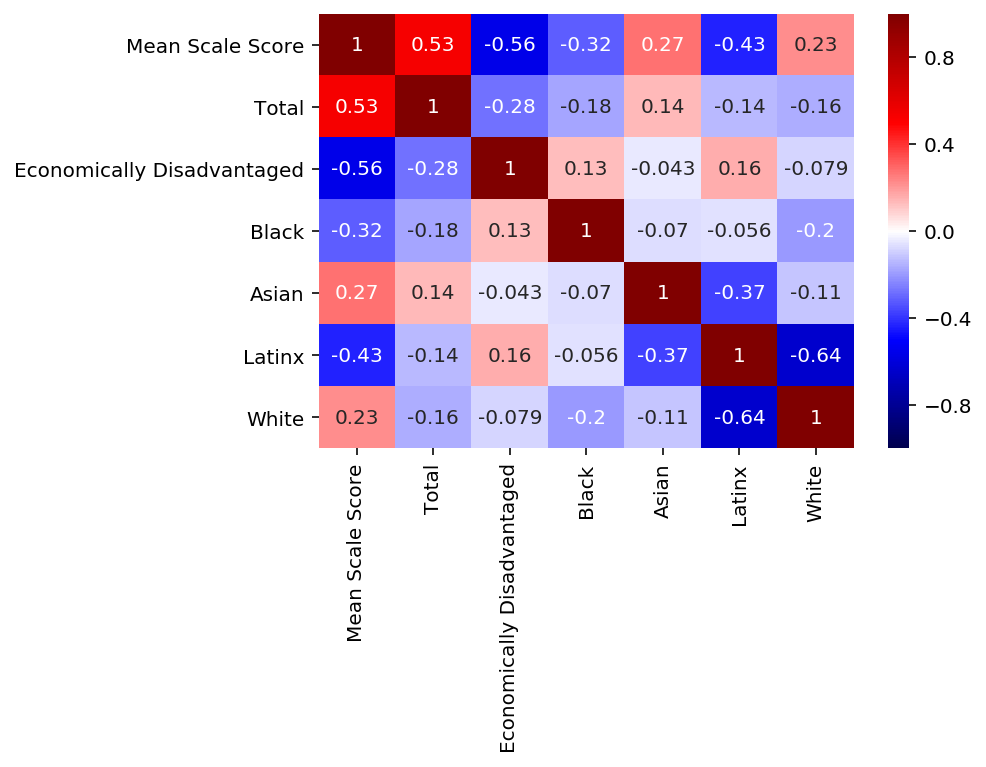

In [188]:
english_model_df = english_model[['Mean Scale Score', 'Total', 'Economically Disadvantaged', 'Black', 'Asian', 'Latinx', 'White']]
english_model_df['Mean Scale Score'] = pd.to_numeric(english_model_df['Mean Scale Score'])
english_model_df.corr()
sns.heatmap(english_model_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [189]:
english_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1619 entries, 132 to 143963
Data columns (total 7 columns):
Mean Scale Score              1619 non-null float64
Total                         1619 non-null int64
Economically Disadvantaged    1619 non-null float64
Black                         1619 non-null float64
Asian                         1619 non-null float64
Latinx                        1619 non-null float64
White                         1619 non-null float64
dtypes: float64(6), int64(1)
memory usage: 181.2 KB


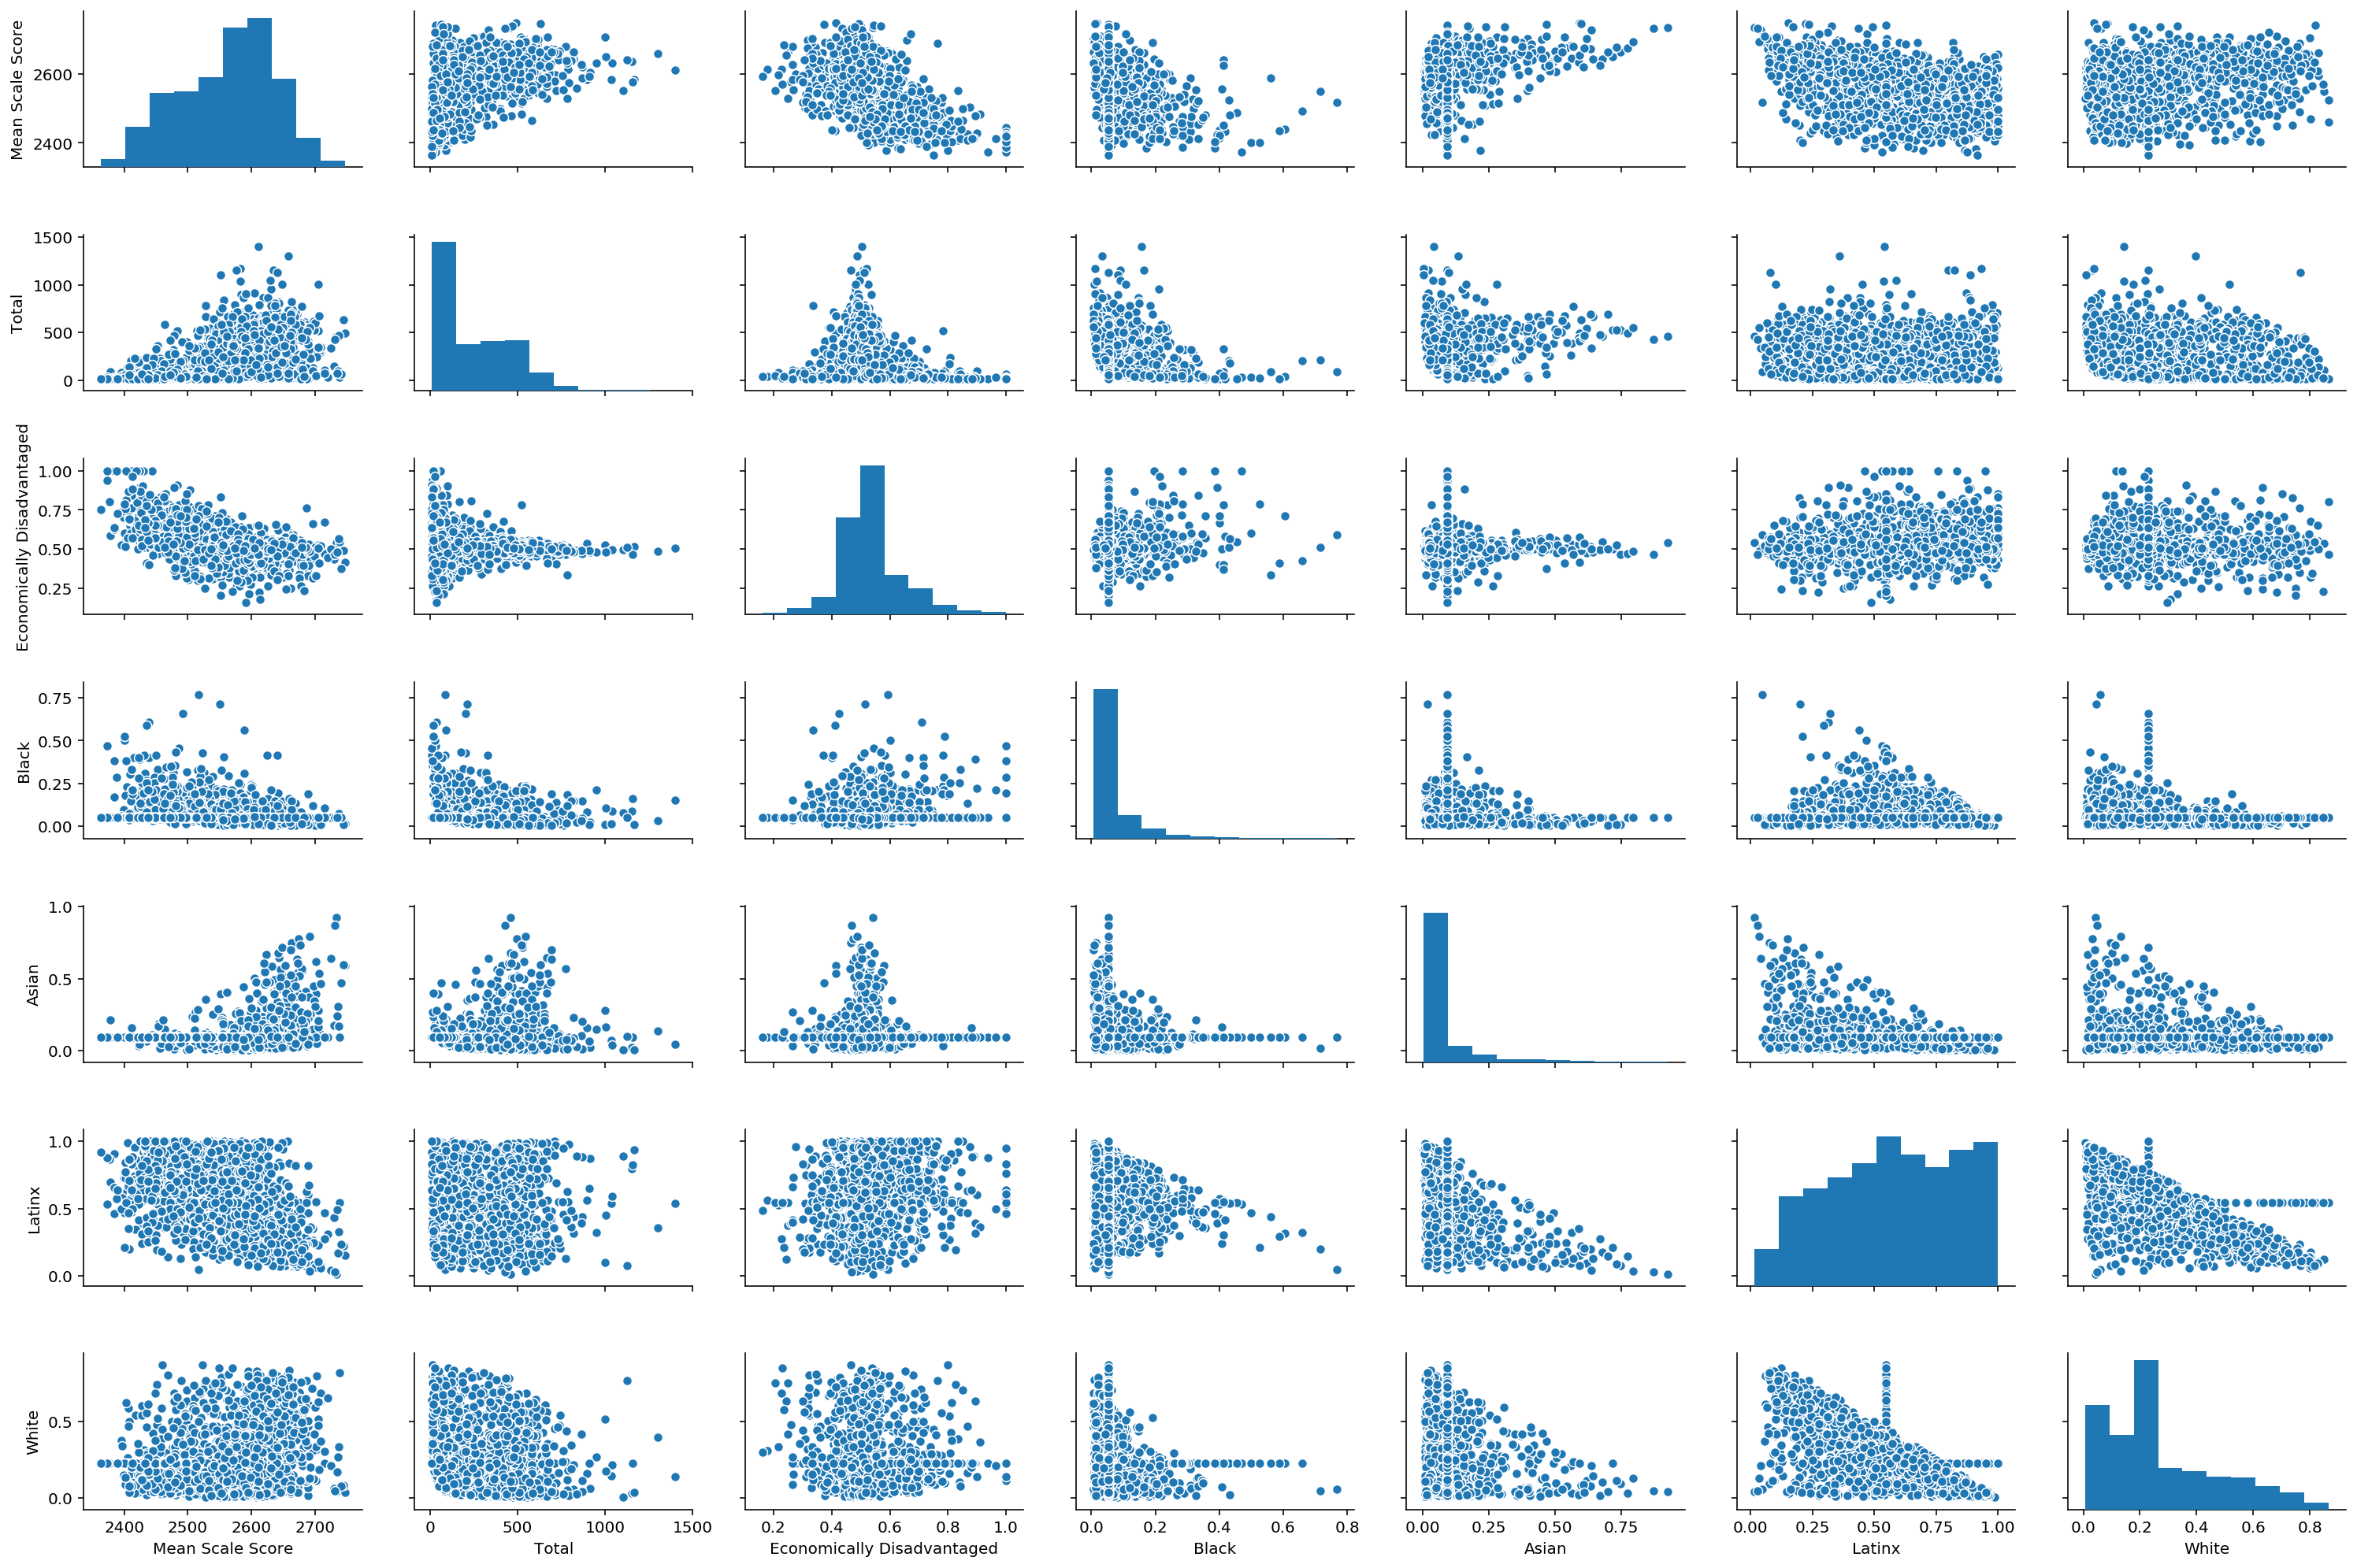

In [190]:
sns.pairplot(english_model_df, height=2, aspect=1.5)

## StatsModels

In [191]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices("Q('Mean Scale Score') ~ Total + 'Q('Economically Disadvantaged')' + Black + Asian + Latinx + White", data=english_model_df, return_type="dataframe")
X
# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

PatsyError: error tokenizing input (maybe an unclosed string?)
    Q('Mean Scale Score') ~ Total + Q('Economically Disadvantaged')' + Black + Asian + Latinx + White
                                                                   ^

In [195]:
# Define the model
lm1 = smf.ols("Q('Mean Scale Score') ~ Total + Q('Economically Disadvantaged') + Black + Asian + Latinx + White", data=english_model_df)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Q('Mean Scale Score')   R-squared:                       0.625
Model:                               OLS   Adj. R-squared:                  0.624
Method:                    Least Squares   F-statistic:                     448.1
Date:                   Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                           15:55:37   Log-Likelihood:                -8489.7
No. Observations:                   1619   AIC:                         1.699e+04
Df Residuals:                       1612   BIC:                         1.703e+04
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2722.8344     11.379    239.296      0.000    2700.516    2745.153
Total                               0.1185      0.006     19.482      0.000       0.107       0.130
Q('Economically Disadvantaged')  -270.1219     11.236    -24.041      0.000    -292.161    -248.083
Black                            -204.4346     17.959    -11.383      0.000    -239.660    -169.209
Asian                              74.3919     14.555      5.111      0.000      45.843     102.941
Latinx                            -76.0031      8.267     -9.194      0.000     -92.218     -59.788
White                              19.4899     10.286      1.895      0.058      -0.685      39.665
==============================================================================
Omnibus:                       39.261   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.648
Skew:                           0.189   Prob(JB):                     2.04e-15
Kurtosis:                       3.927   Cond. No.                     6.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [196]:
# Define the model
lm2 = smf.ols("Q('Mean Scale Score') ~ Total + Q('Economically Disadvantaged') + Black + Asian + Latinx", data=english_model_df)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Q('Mean Scale Score')   R-squared:                       0.624
Model:                               OLS   Adj. R-squared:                  0.623
Method:                    Least Squares   F-statistic:                     536.2
Date:                   Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                           15:55:39   Log-Likelihood:                -8491.5
No. Observations:                   1619   AIC:                         1.699e+04
Df Residuals:                       1613   BIC:                         1.703e+04
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2739.5637      7.184    381.364      0.000    2725.474    2753.654
Total                               0.1136      0.006     20.592      0.000       0.103       0.124
Q('Economically Disadvantaged')  -269.8841     11.244    -24.002      0.000    -291.939    -247.829
Black                            -221.4842     15.555    -14.239      0.000    -251.994    -190.975
Asian                              58.7867     12.011      4.895      0.000      35.229      82.345
Latinx                            -88.7306      4.823    -18.397      0.000     -98.191     -79.270
==============================================================================
Omnibus:                       41.263   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.881
Skew:                           0.197   Prob(JB):                     2.46e-16
Kurtosis:                       3.954   Cond. No.                     4.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [197]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

lasso_model = Lasso(alpha = .0019) 
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.0019, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [198]:
selected_columns = ['Total', 'Economically Disadvantaged', 'Black', 'Asian', 'Latinx', 'White']
list(zip(selected_columns, lasso_model.coef_))

[('Total', 0.10812866931492143),
 ('Economically Disadvantaged', -295.8832186944495),
 ('Black', -194.60379857325086),
 ('Asian', 80.58141780928435),
 ('Latinx', -70.2055575549985),
 ('White', 23.268301384339836)]

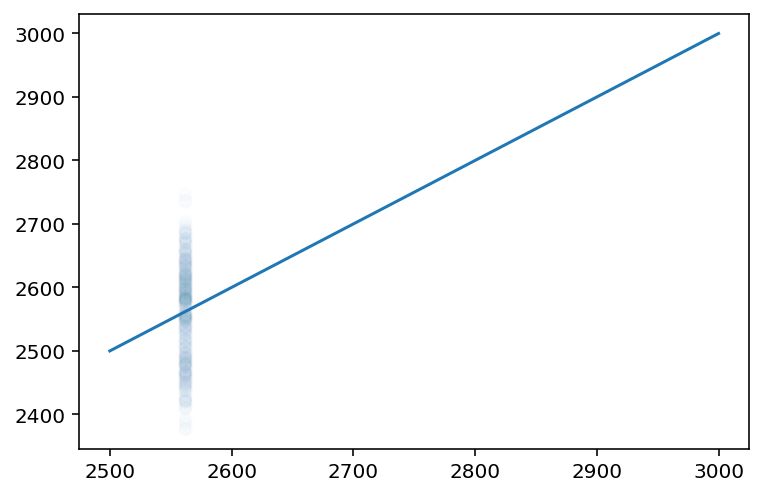

In [256]:
test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
plt.scatter(test_set_pred, y_test, alpha=.01)
plt.plot(np.linspace(2500,3000,100), np.linspace(2500,3000,100));

In [302]:
list(zip(test_set_pred,y_test));

In [299]:
from sklearn.metrics import r2_score
r2_score(y_test, test_set_pred)

0.618950893846151

array([[2.380e+02, 5.378e-01, 5.400e-02, 9.300e-02, 5.294e-01, 4.202e-01],
       [1.470e+02, 5.442e-01, 5.400e-02, 6.122e-02, 8.027e-01, 1.156e-01],
       [1.290e+02, 5.814e-01, 8.527e-02, 9.300e-02, 4.341e-01, 4.651e-01],
       ...,
       [5.630e+02, 5.577e-01, 8.881e-03, 1.421e-02, 9.183e-01, 2.309e-02],
       [3.200e+01, 1.000e+00, 4.688e-01, 9.300e-02, 5.312e-01, 2.290e-01],
       [1.200e+01, 5.833e-01, 5.400e-02, 9.300e-02, 3.333e-01, 2.290e-01]])

In [202]:
y_train = y_train.astype(float)

In [205]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     270.6
Date:                Thu, 23 Jan 2020   Prob (F-statistic):          8.95e-203
Time:                        15:56:29   Log-Likelihood:                -5079.0
No. Observations:                 971   AIC:                         1.017e+04
Df Residuals:                     964   BIC:                         1.021e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2733.6695     14.191    192.632      0.000    2705.820    2761.519
x1             0.1081      0.008     14.294      0.000       0.093       0.123
x2          -296.0436     14.592    -20.289      0.000    -324.679    -267.408
x3          -194.8384     21.518     -9.055      0.000    -237.065    -152.612
x4            80.7860     18.201      4.439      0.000      45.069     116.503
x5           -70.1791     10.453     -6.714      0.000     -90.692     -49.666
x6            23.3175     12.895      1.808      0.071      -1.987      48.622
==============================================================================
Omnibus:                       21.532   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.699
Skew:                           0.211   Prob(JB):                     1.31e-07
Kurtosis:                       3.778   Cond. No.                     6.55e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [276]:
lr_model_ridge = Ridge(alpha = 18.04186409392072)
lr_model_ridge.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('Total', 0.14813248083702577),
 ('Economically Disadvantaged', -110.20968731908204),
 ('Black', -53.01572380923085),
 ('Asian', 35.98061914889682),
 ('Latinx', -57.37268033527394),
 ('White', 38.48620039297954)]

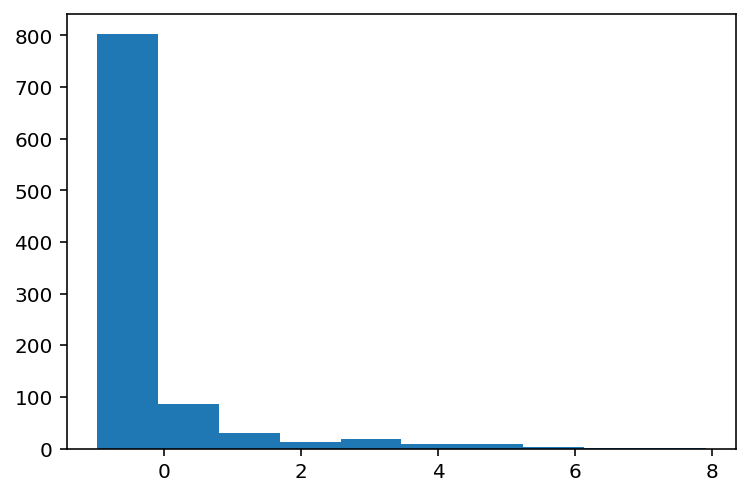

In [251]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

std = StandardScaler()
std.fit(X_train.values)

## This step applies the scaler to the train set.
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

X_tr = std.transform(X_train.values)

## Apply the scaler to the test set

X_te = std.transform(X_test.values)

## Note that even though we put a Pandas Dataframe into the scalar, what comes out is a numpy array
## In general, sklearn works on numpy.  It will accept pandas objects by trying to coerce them to numpy arrays
## But it will not usually output pandas objects

type(X_train), type(X_tr)

## Here we can plot histograms of the transformed variables
## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)

plt.hist(X_tr[:,3])

## Fit a LASSO model on the standardized data

lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_tr,y_train)

## Note that now we can meaningful compare the importance of
## different features, since they're on the same scale

## But it's now difficult to interpret the coefficients
## We would need to translate back to the original feature scales by dividing
## each coefficient by the original column's standard deviation

list(zip(X_train.columns, lasso_model.coef_))

test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])

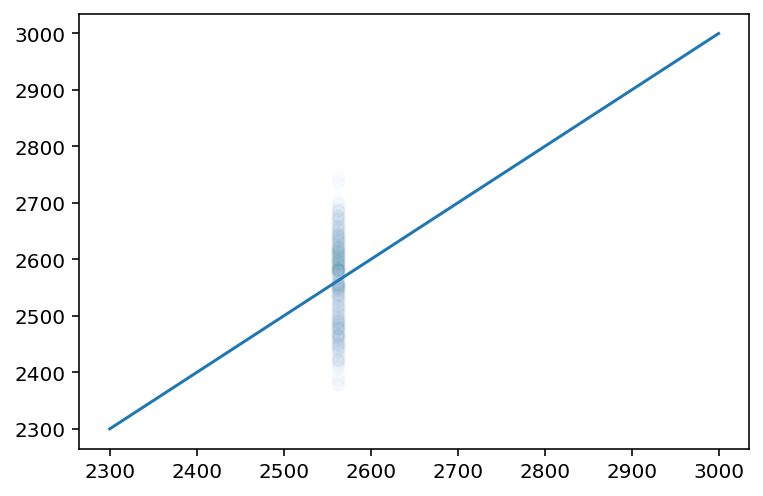

In [255]:
plt.scatter(test_set_pred, y_test, alpha=.01)
plt.plot(np.linspace(2300,3000,100), np.linspace(2300,3000,100))

In [239]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

35.78865925054286

In [237]:
y_val = round(y_val).astype(int)
val_set_pred = (val_set_pred).astype(int)

In [277]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

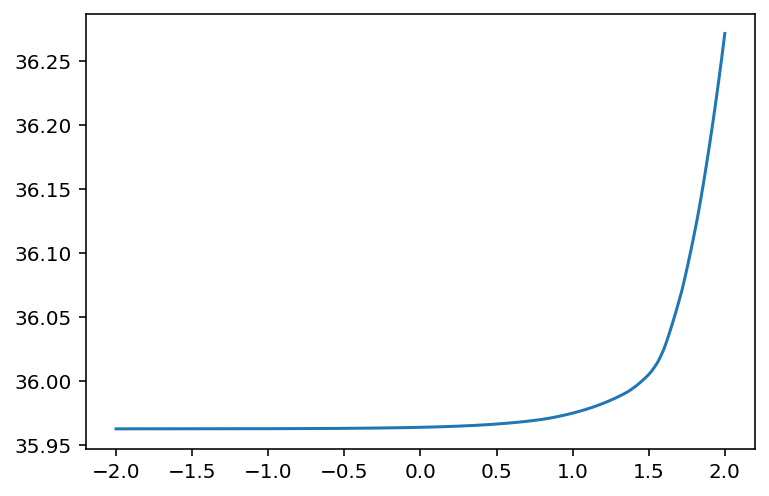

In [278]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [279]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

35.96239850944559

In [280]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.01

In [281]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [282]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [283]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lr_model_ridge = RidgeCV(alphas = alphavec, cv=5)
lr_model_ridge.fit(X_tr, y_train)

RidgeCV(alphas=array([1.000e-02, 1.047e-02, 1.097e-02, 1.149e-02, 1.203e-02, 1.260e-02,
       1.320e-02, 1.383e-02, 1.448e-02, 1.517e-02, 1.589e-02, 1.664e-02,
       1.743e-02, 1.825e-02, 1.912e-02, 2.002e-02, 2.097e-02, 2.196e-02,
       2.300e-02, 2.409e-02, 2.524e-02, 2.643e-02, 2.768e-02, 2.899e-02,
       3.037e-02, 3.181e-02, 3.331e-02, 3.489e-02, 3.654e-02, 3.827e-02,
       4.009e-02, 4.199e-02, 4.398e-0...
       3.144e+01, 3.293e+01, 3.449e+01, 3.612e+01, 3.783e+01, 3.963e+01,
       4.150e+01, 4.347e+01, 4.553e+01, 4.769e+01, 4.995e+01, 5.231e+01,
       5.479e+01, 5.738e+01, 6.010e+01, 6.295e+01, 6.593e+01, 6.906e+01,
       7.233e+01, 7.575e+01, 7.934e+01, 8.310e+01, 8.704e+01, 9.116e+01,
       9.548e+01, 1.000e+02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [284]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lr_model_ridge.alpha_

18.04186409392072

In [285]:
lr_model_ridge = Ridge(alpha = 18.04186409392072)
lr_model_ridge.fit(X_tr, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('Total', 23.903977130842716),
 ('Economically Disadvantaged', -30.991874698173696),
 ('Black', -15.342873421717213),
 ('Asian', 8.447737203740285),
 ('Latinx', -17.547556442227343),
 ('White', 4.939228150560646)]

In [261]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
#list(zip(X_train.columns, lasso_model.coef_))

[('Total', 23.857028314543463),
 ('Economically Disadvantaged', -31.26949033668279),
 ('Black', -15.548159875658406),
 ('Asian', 8.051616330586626),
 ('Latinx', -18.16606075307831),
 ('White', 4.285393703390838)]

In [288]:
test_set_pred = lr_model_ridge.predict(X_te)

In [291]:
test_set_pred.dtype

dtype('float64')

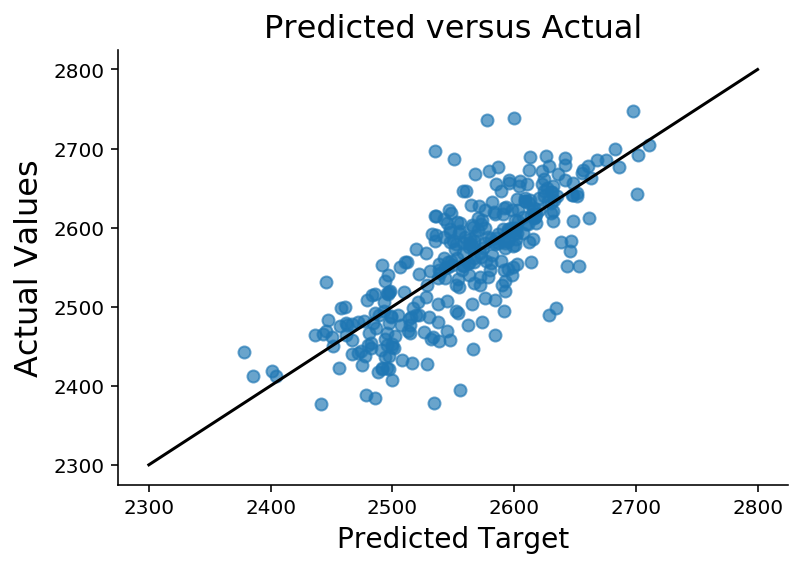

In [362]:
#pred vs test
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(test_set_pred, y_test, alpha=.67)
plt.plot(np.linspace(2300,2800,100), np.linspace(2300,2800,100), color = 'black')
plt.xlabel('Predicted Target', size=14)
sns.despine()
plt.ylabel('Actual Values', size=16)
plt.title('Predicted versus Actual',
          size=16)
plt.savefig('basic_model.svg', format='svg', transparent=True)

In [326]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_tr, y_train)

# Print out the R^2 for the model against the full dataset
r_squared = lr.score(X_tr,y_train)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_tr.shape[1]-1)
print(adjusted_r_squared)

0.6251724867865478


In [325]:
y_predict = lr.predict(X_te)
r_squared = lr.score(X_te, y_test)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_te.shape[1]-1)
print(adjusted_r_squared)

0.6122082123365662


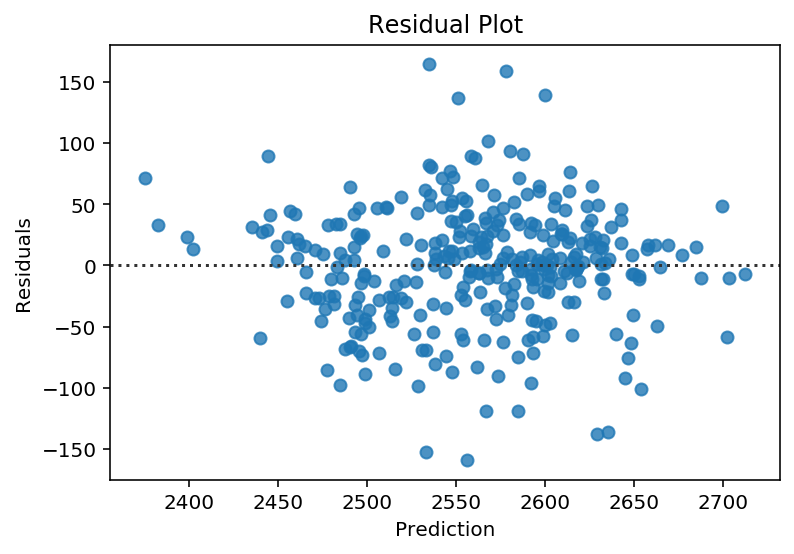

In [380]:
# create residual plot
res = y_test - y_predict
ax = sns.residplot(y_predict, res)
ax.set(title="Residual Plot" ,xlabel="Prediction", ylabel="Residuals")
plt.savefig("residuals.svg", transparent = True)

In [363]:
model = sm.OLS(y_train, sm.add_constant(X_tr))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Mean Scale Score   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     270.6
Date:                Thu, 23 Jan 2020   Prob (F-statistic):          8.95e-203
Time:                        23:39:18   Log-Likelihood:                -5079.0
No. Observations:                 971   AIC:                         1.017e+04
Df Residuals:                     964   BIC:                         1.021e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2561.8872      1.457   1758.664      0.000    2559.029    2564.746
x1            24.0941      1.686     14.294      0.000      20.786      27.402
x2           -31.4214      1.549    -20.289      0.000     -34.461     -28.382
x3           -15.6240      1.725     -9.055      0.000     -19.010     -12.238
x4             8.3599      1.883      4.439      0.000       4.664      12.056
x5           -18.0086      2.682     -6.714      0.000     -23.272     -12.745
x6             4.6777      2.587      1.808      0.071      -0.399       9.754
==============================================================================
Omnibus:                       21.532   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.699
Skew:                           0.211   Prob(JB):                     1.31e-07
Kurtosis:                       3.778   Cond. No.                         3.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

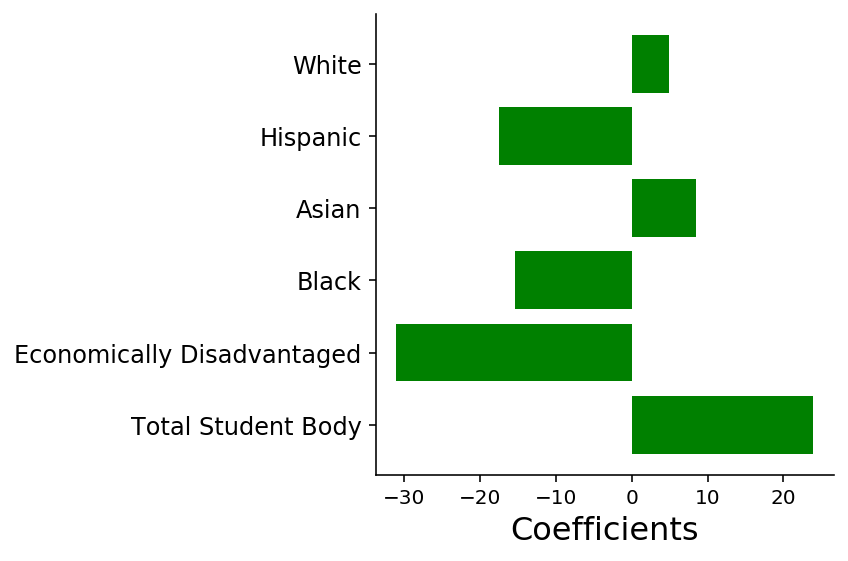

In [387]:
fig, ax = plt.subplots()
plt.barh([
    'Total',
    'Economically Disadvantaged',
    'Black',
    'Asian',
    'Hispanic',
    'White'
], [23.903977130842716, -30.991874698173696, -15.342873421717213, 8.447737203740285, -17.547556442227343, 4.939228150560646],color='green')
#ax.set_yticks(np.arange((lm.coef_)))
plt.xlabel('Coefficients', size=16)
sns.despine()
ax.set_yticklabels([
    'Total Student Body',
    'Economically Disadvantaged',
    'Black',
    'Asian',
    'Hispanic',
    'White'
], size=12)
     
# [('Total', 23.903977130842716),
#  ('Economically Disadvantaged', -30.991874698173696),
#  ('Black', -15.342873421717213),
#  ('Asian', 8.447737203740285),
#  ('Latinx', -17.547556442227343),
#  ('White', 4.939228150560646)]
              
              
plt.tight_layout()
plt.savefig('coefficient.svg', transparent = True);